# Рубежный контроль №2

# Кондрахин Сергей ИУ5-61Б

# Вариант 9

# Задание

Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from typing import Dict

In [2]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

Был создан датафрейм, содержащий 12 нецелевых признаков и 1 целевой - смерть пациента

In [3]:
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [4]:
data_y = data['DEATH_EVENT']
data_y

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

Типы данных всех полей являются числовыми

In [5]:
data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

В наборе данных отсутствуют дубликаты и пропуски

In [6]:
data.duplicated().sum()

0

In [7]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Проведем корреляционный анализ, чтобы оценить вклад признаков для построения моделей классификации. Для визуализации корреляционной матрицы была использована тепловая карта.

<Axes: >

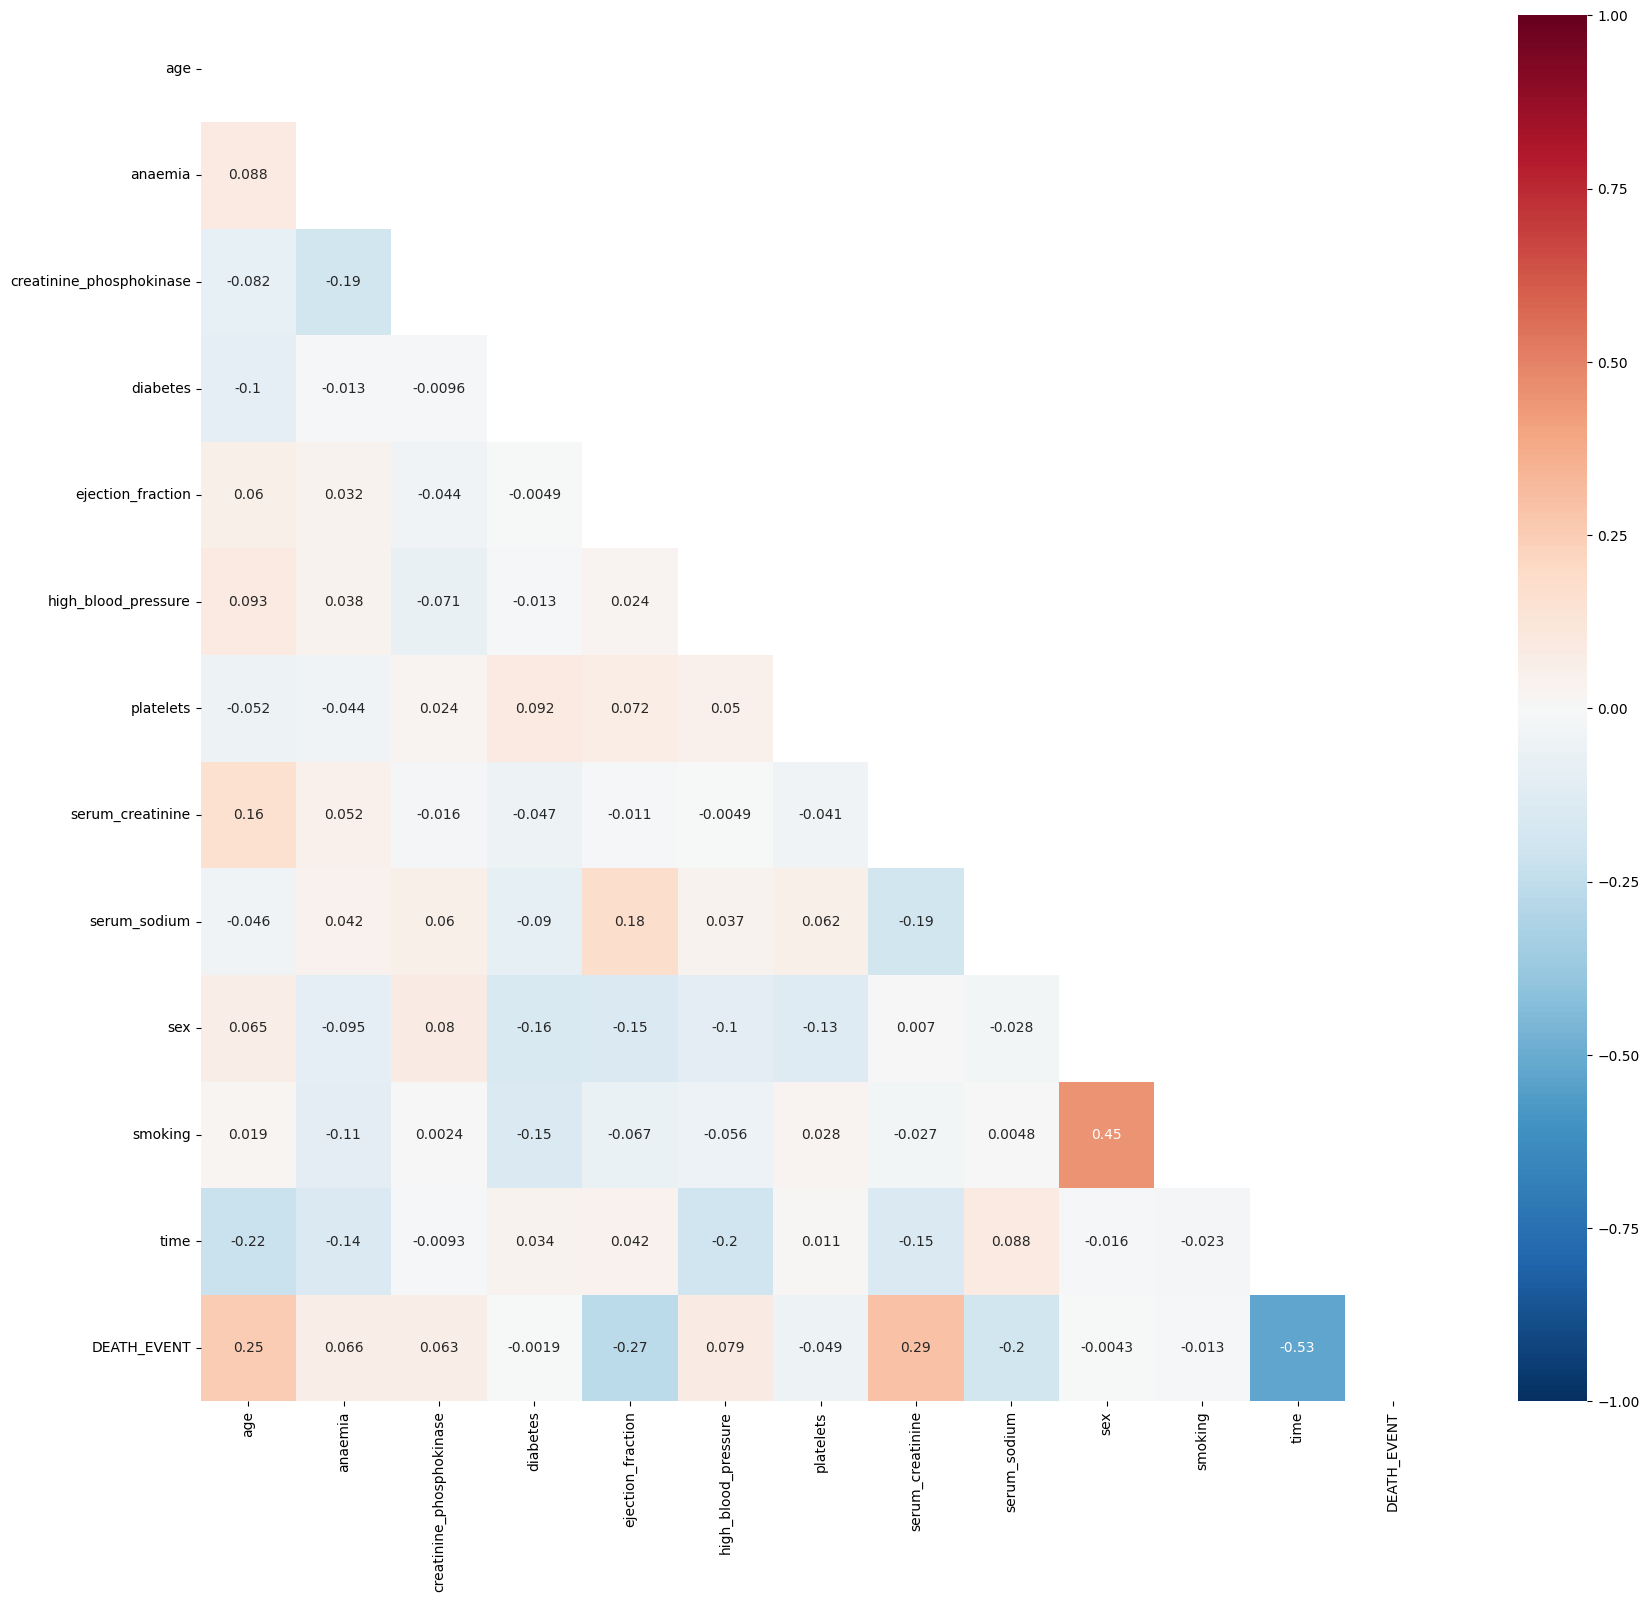

In [8]:
plt.figure(figsize=(20, 18))
mask=np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(), mask=mask, annot=True, vmin=-1.0, vmax=1, center=0, cmap='RdBu_r')

С целевым признаком наиболее сильную корреляцию имеют признаки 'time' (-0.53), 'ejection_fraction' (-0.27), 'serum_sodium' (-0.2), 'age' (0.25), 'serum_creatinine' (0.29). Эти признаки будут наиболее информативны при построении моделей машинного обучения. Остальные признаки слабо коррелируют с целевым признаком и могут негативно сказаться на модели машинного обучения, поэтому их стоит исключить из модели. В целом остальные нецелевые признаки не коррелируют друг с другом так сильно, поэтому их всех можно использовать для построения модели машинного обучения. Таким образом, на основе признаков 'time', 'ejection_fraction', 'serum_sodium', 'age', 'serum_creatinine' могут быть построены модели машинного обучения.

Разобьем исходную выборку на обучающую и тестовую

In [9]:
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data[['time', 'ejection_fraction','serum_sodium','age','serum_creatinine']], data['DEATH_EVENT'].values, test_size=0.2, random_state=2)

Выборка не является полностью сбалансированной. Для балансировки выборки воспользуемся методом oversampling (увеличение выборки) с использованием алгоритма SMOTE.

In [10]:
class_counts = pd.Series(data_y_train).value_counts()
print(class_counts)

0    160
1     79
dtype: int64


Создаем экземпляр класса SMOTE

In [11]:
smote = SMOTE(random_state=2)

Применяем метод увеличения выборки к обучающей выборке

In [12]:
data_X_train_resampled, data_y_train_resampled = smote.fit_resample(data_X_train, data_y_train)

In [13]:
class_counts_resampled = pd.Series(data_y_train_resampled).value_counts()
print(class_counts_resampled)

1    160
0    160
dtype: int64


Было произведено MinMax масштабирование данных

In [14]:
mms = MinMaxScaler()

In [15]:
data_X_train_scaled = mms.fit_transform(data_X_train_resampled)
data_X_test_scaled = mms.fit_transform(data_X_test)

Была обучена модель логической регрессии

In [16]:
cl=LogisticRegression(multi_class='multinomial')

In [17]:
cl.fit(data_X_train_scaled, data_y_train_resampled)

LogisticRegression(multi_class='multinomial')

Результаты классификации с использованием модели логической регрессии

In [18]:
pred_data_y_test = cl.predict(data_X_test_scaled)
pred_data_y_test

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

Для оценки качества моделей машинного обучения были использованы метрики accuracy и F1-мера. Метрика accuracy подходит для оценки качества моделей классификации для заданного набора данных, так как классификация производится по двум равноценным классам и нет необходимости в более точном определении того или иного класса. Метрика F1-мера подходит для оценки качества моделей классификации для заданного набора данных, так как в случае классификации по двум равноценным классам precision и recall имеют равноценное значение, поэтому их оценку можно совместить в метрику F1-мера.

Значение метрики accuracy

In [19]:
accuracy_score(data_y_test, pred_data_y_test)

0.9

Функции вывода занчения метрики accuracy для каждого класса

In [20]:
def accuracy_score_for_classes(y_true:np.ndarray, y_pred:np.ndarray) -> Dict[int, float]:
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    classes = np.unique(y_true)
    res = dict()
    for c in classes:
        temp_data_flt = df[df['t']==c]
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, temp_data_flt['p'].values
        )
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(y_true: np.ndarray, y_pred: np.ndarray):
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

Значение метрики accuracy для каждого класса

In [21]:
print_accuracy_score_for_classes(data_y_test, pred_data_y_test)

Метка 	 Accuracy
0 	 0.9302325581395349
1 	 0.8235294117647058


Значение метрики F1-мера

In [22]:
f1_score(data_y_test, pred_data_y_test, average=None)

array([0.93023256, 0.82352941])

Была обучена модель случайного леса

In [23]:
data_rl_cf = RandomForestClassifier(random_state=2)
data_rl_cf.fit(data_X_train_scaled, data_y_train_resampled)

RandomForestClassifier(random_state=2)

Результаты классификации с использованием модели случайного леса

In [24]:
pred_data_rf_y_test = data_rl_cf.predict(data_X_test_scaled)
pred_data_rf_y_test

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

Значение метрики accuracy для модели случайного леса

In [25]:
accuracy_score(data_y_test, pred_data_rf_y_test)

0.8666666666666667

Значение метрики accuracy для каждого класса

In [26]:
print_accuracy_score_for_classes(data_y_test, pred_data_rf_y_test)

Метка 	 Accuracy
0 	 0.8837209302325582
1 	 0.8235294117647058


Значение метрики F1-мера для модели случайного леса для каждого класса

In [27]:
f1_score(data_y_test, pred_data_rf_y_test, average=None)

array([0.9047619 , 0.77777778])

Таким образом модель логистической регрессии производит классификацию лучше, чем модель случайного леса.